# Bayesian Networks

In [1]:
import sys
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.independencies.Independencies import IndependenceAssertion
from pgmpy.inference import VariableElimination


sys.path.append('scripts')
from utils import *

/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create the Student Network from [Probabilistic Graphical Models: Principles and Techniques by Daphne Koller](https://www.goodreads.com/en/book/show/6676555)

In [37]:
student_model = BayesianModel([('Difficulty', 'Grade'),
                               ('Intelligence', 'Grade'),
                               ('Grade', 'Letter'),
                               ('Intelligence', 'SAT')])

cpd_difficulty = TabularCPD(variable='Difficulty', variable_card=2,
                            values=[[0.6], [0.4]],
                            state_names={'Difficulty': ['Easy', 'Hard']})
cpd_intelligence = TabularCPD(variable='Intelligence', variable_card=2,
                              values=[[0.7], [0.3]],
                              state_names={'Intelligence': ['Low', 'High']})
cpd_grade = TabularCPD(variable='Grade', variable_card=3,
                       values=[[0.3, 0.05, 0.9, 0.5],
                               [0.4, 0.25, 0.08, 0.3],
                               [0.3, 0.7, 0.02, 0.2]],
                       evidence=['Difficulty', 'Intelligence'],
                       evidence_card=[2, 2],
                       state_names={'Grade': ['A', 'B', 'C'],
                                    'Difficulty': ['Easy', 'Hard'],
                                    'Intelligence': ['Low', 'High']})
cpd_letter = TabularCPD(variable='Letter', variable_card=2,
                        values=[[0.1, 0.4, 0.99],
                                [0.9, 0.6, 0.01]],
                        evidence=['Grade'],
                        evidence_card=[3],
                        state_names={'Letter': ['Good', 'Bad'],
                                     'Grade': ['A', 'B', 'C']})
cpd_sat = TabularCPD(variable='SAT', variable_card=2,
                     values=[[0.95, 0.2],
                             [0.05, 0.8]],
                     evidence=['Intelligence'],
                     evidence_card=[2],
                     state_names={'SAT': ['Good', 'Bad'],
                                  'Intelligence': ['Low', 'High']})


student_model.add_cpds(cpd_difficulty, cpd_intelligence, cpd_grade, cpd_letter, cpd_sat)

In [38]:
# check if model is created correctly
student_model.check_model()

True

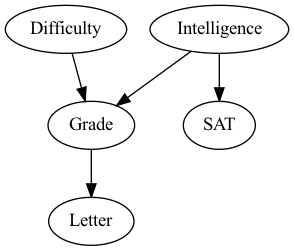

In [60]:
ASSETS_FOLDER = 'assets/'
display_bayesian_model(student_model, ASSETS_FOLDER+ 'student_network.png')


In [39]:
print(student_model.get_cpds('Grade'))

+--------------+-------------------+-----+--------------------+
| Difficulty   | Difficulty(Easy)  | ... | Difficulty(Hard)   |
+--------------+-------------------+-----+--------------------+
| Intelligence | Intelligence(Low) | ... | Intelligence(High) |
+--------------+-------------------+-----+--------------------+
| Grade(A)     | 0.3               | ... | 0.5                |
+--------------+-------------------+-----+--------------------+
| Grade(B)     | 0.4               | ... | 0.3                |
+--------------+-------------------+-----+--------------------+
| Grade(C)     | 0.3               | ... | 0.2                |
+--------------+-------------------+-----+--------------------+


In [14]:
student_model.get_markov_blanket('Grade')

['Letter', 'Intelligence', 'Difficulty']

In [40]:
student_variables = ['Difficulty', 'Intelligence', 'Grade', 'SAT', 'Letter']
# check independencies                     
student_model.local_independencies(student_variables)

(Difficulty ⟂ SAT, Intelligence)
(Intelligence ⟂ Difficulty)
(Grade ⟂ SAT | Difficulty, Intelligence)
(SAT ⟂ Difficulty, Grade, Letter | Intelligence)
(Letter ⟂ Difficulty, SAT, Intelligence | Grade)

## Construct a Bayesian Network for given conditions

(A ⟂ B): True
(A ⟂ D | C): True
(B ⟂ D | C, A): True


(A ⟂ D | B): False
(A ⟂ C): False
(B ⟂ C): False
(A ⟂ B | D): False

In [20]:
def check_assertion(model, independent, from_variables, evidence):
    assertion = IndependenceAssertion(independent, from_variables, evidence)
    result = False
    for a in model.get_independencies().get_assertions():
        if frozenset(assertion.event1) == a.event1 and assertion.event2 <= a.event2 and frozenset(assertion.event3) == a.event3:
            result = True
            break
    print(f'{assertion}: {result}')

In [24]:
conditional_model = BayesianModel([('A', 'C'), ('B', 'C'), ('C', 'D')])

check_assertion(conditional_model, independent=['A'], from_variables=['B'], evidence=[])
check_assertion(conditional_model, independent=['A'], from_variables=['D'], evidence=['C'])
check_assertion(conditional_model, independent=['B'], from_variables=['D'], evidence=['A', 'C'])
print("---")
check_assertion(conditional_model, independent=['A'], from_variables=['D'], evidence=['B'])
check_assertion(conditional_model, independent=['A'], from_variables=['C'], evidence=[])
check_assertion(conditional_model, independent=['B'], from_variables=['C'], evidence=[])
check_assertion(conditional_model, independent=['A'], from_variables=['B'], evidence=['D'])

(A ⟂ B): True
(A ⟂ D | C): True
(B ⟂ D | A, C): True
---
(A ⟂ D | B): False
(A ⟂ C): False
(B ⟂ C): False
(A ⟂ B | D): False


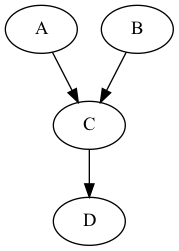

In [25]:
ASSETS_FOLDER = 'assets/'
display_bayesian_model(conditional_model, ASSETS_FOLDER+ 'conditional_network.png')

## Variable Elimination and Inference

Back to the Student Network, we know that:

$P(D, I, G, L, S) = P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

Now let's say we just want to compute the probability of G. For that we will need to marginalize over all the other variables.

$P(G) = \sum_{D, I, L, S} P(D, I, G, L, S)$

$P(G) = \sum_{D, I, L, S} P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

$P(G) = \sum_D \sum_I \sum_L \sum_S P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

Now since not all the conditional distributions depend on all the variables we can push the summations inside:

$P(G) = \sum_D \sum_I \sum_L \sum_S P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

$P(G) = \sum_D P(D) \sum_I P(G|D, I) * P(I) \sum_S P(S|I) \sum_L P(L|G)$

So, by pushing the summations inside we have saved a lot of computation because we have to now iterate over much smaller tables.

Let's take an example for inference using Variable Elimination in pgmpy:

In [43]:
infer = VariableElimination(student_model)
print(infer.query(['Grade'], elimination_order= 'MinNeighbors', show_progress=True))

Eliminating: Intelligence: 100%|███████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1748.36it/s]

+----------+--------------+
| Grade    |   phi(Grade) |
+==========+==============+
| Grade(A) |       0.4470 |
+----------+--------------+
| Grade(B) |       0.2714 |
+----------+--------------+
| Grade(C) |       0.2816 |
+----------+--------------+


## Variable Elimination with Evidence

In [44]:
print(infer.query(['Grade'], evidence={'Difficulty': 'Easy', 'Intelligence': 'High'}, elimination_order= 'MinNeighbors', show_progress=True))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+----------+--------------+
| Grade    |   phi(Grade) |
+==========+==============+
| Grade(A) |       0.0500 |
+----------+--------------+
| Grade(B) |       0.2500 |
+----------+--------------+
| Grade(C) |       0.7000 |
+----------+--------------+


## Predicting new data points

This is similar query but instead of getting the probability distribution, we are just concern of the most probable state for the query.

In [45]:
infer.map_query(['Grade'])

Eliminating: Intelligence: 100%|███████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1078.23it/s]


{'Grade': 'A'}

In [46]:
infer.map_query(['Grade'], 
                evidence={'Difficulty': 'Easy', 
                          'Intelligence': 'Low', 
                          'Letter': 'Bad', 
                          'SAT': 'Bad'})

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


{'Grade': 'A'}

In [48]:
print(infer.query(['Grade'], 
                evidence={'Difficulty': 'Easy', 
                          'Intelligence': 'Low', 
                          'Letter': 'Bad', 
                          'SAT': 'Bad'}))

+----------+--------------+
| Grade    |   phi(Grade) |
+==========+==============+
| Grade(A) |       0.5263 |
+----------+--------------+
| Grade(B) |       0.4678 |
+----------+--------------+
| Grade(C) |       0.0058 |
+----------+--------------+
